In [161]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import MobileNetV2
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.metrics import CategoricalCrossentropy
from keras.layers import GlobalMaxPooling2D, Dense
from keras.utils import plot_model
import seaborn as sns
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import os

In [162]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [163]:
dirpath = os.getcwd()
PATH = os.path.join(dirpath, "drive/MyDrive/College/Boise State University/FALL 2024/CS597/assignment01/")

Train Image Shape:  (32, 32, 3)
Validation Image Shape:  (32, 32, 3)
Test Image Shape:  (32, 32, 3)



-------------------------
 Number of Image Batches
-------------------------
Training Images:  1094
Validation Images:  469
Test Images:  313


Total Images:  1876
-------------------------




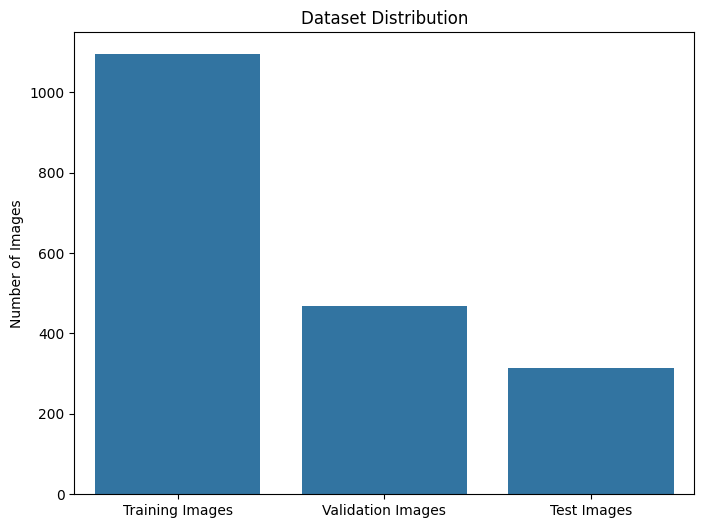

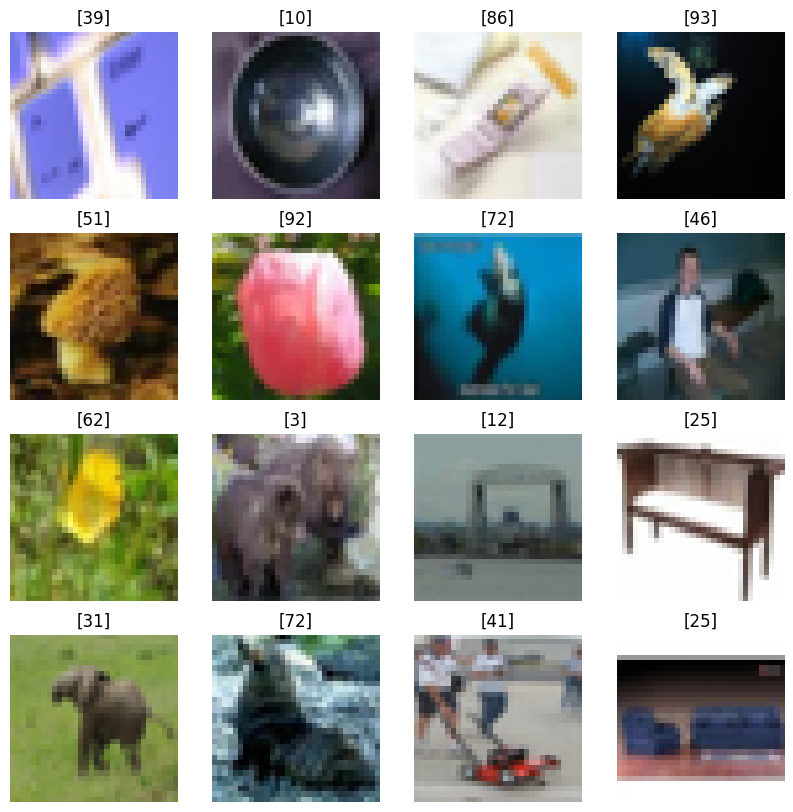

In [164]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

training_dataset = tf.data.Dataset.from_tensor_slices((x_train, keras.utils.to_categorical(y_train))).batch(batch_size=32)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation, keras.utils.to_categorical(y_validation))).batch(batch_size=32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, keras.utils.to_categorical(y_test))).batch(batch_size=32)

print("Train Image Shape: ", x_train.shape[1:])
print("Validation Image Shape: ", x_validation.shape[1:])
print("Test Image Shape: ", x_test.shape[1:])
print("\n\n")

num_training = len(training_dataset)
num_validation = len(validation_dataset)
num_test = len(test_dataset)
num_total = num_training + num_validation + num_test

print("-------------------------")
print(" Number of Image Batches")
print("-------------------------")
print("Training Images: ", num_training)
print("Validation Images: ", num_validation)
print("Test Images: ", num_test)
print("\n")
print("Total Images: ", num_total)
print("-------------------------")
print("\n")

labels = ["Training Images", "Validation Images", "Test Images"]
distribution = [num_training, num_validation, num_test]

dir_to_save = PATH
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=distribution)
plt.ylabel("Number of Images")
plt.title("Dataset Distribution")
plt.savefig(os.path.join(dir_to_save, "dataset_distribution.png"), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis("off")
plt.show()

In [165]:
base_model = MobileNetV2(
    input_shape=(32, 32, 3),
    alpha=1.0,
    include_top=False,
    weights=None,
    pooling="Max"
)

model = keras.Sequential([
    base_model,
    Flatten(),
    Dense(100, activation="softmax")
])

model.build(input_shape=(None, 32, 32, 3))

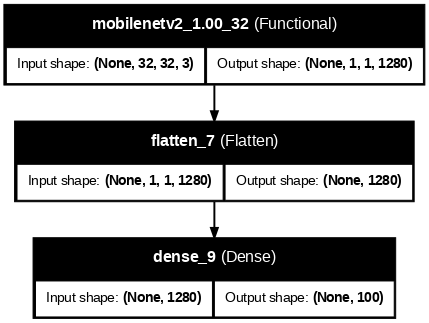

In [166]:
num_epochs = 50

metrics = [
    "accuracy",
    "precision",
    "recall",
    "f1_score"
]

model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=metrics)

model_name = "model.trial1"
save_dir = os.path.join(PATH, model_name + ".keras")
csv_logger = CSVLogger("training.log", separator=',', append=False)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1)
checkpoint_save = ModelCheckpoint(save_dir, monitor="val_loss", save_best_only=True)
reduce_lr_loss = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1, min_delta=1e-4)

plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70
)

In [167]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_32 (Functional)     │ (None, 1, 1, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │         128,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,386,084 (9.10 MB)

 Trainable params: 2,351,972 (8.97 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [168]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep 12 01:57:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              30W /  70W |   2275MiB / 15360MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [169]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
history = model.fit(training_dataset,
                    epochs=num_epochs,
                    steps_per_epoch=len(x_train),
                    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss, csv_logger],
                    validation_data=validation_dataset
                   )

Epoch 1/50
 1094/35000 ━━━━━━━━━━━━━━━━━━━━ 14:34 26ms/step - accuracy: 0.0305 - f1_score: 0.0254 - loss: 4.7310 - precision: 0.0370 - recall: 4.1798e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


35000/35000 ━━━━━━━━━━━━━━━━━━━━ 78s 1ms/step - accuracy: 0.0440 - f1_score: 0.0379 - loss: 4.5085 - precision: 0.0468 - recall: 5.3895e-04 - val_accuracy: 0.0099 - val_f1_score: 1.9541e-04 - val_loss: 4.7222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 19s 544us/step - accuracy: 0.0702 - f1_score: 0.0574 - loss: 4.1596 - precision: 0.1253 - recall: 0.0014 - val_accuracy: 0.0097 - val_f1_score: 1.9148e-04 - val_loss: 4.8516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 16s 469us/step - accuracy: 0.0980 - f1_score: 0.0830 - loss: 3.8811 - precision: 0.1975 - recall: 0.0023 - val_accuracy: 0.0099 - val_f1_score: 1.9541e-04 - val_loss: 5.0074 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 22s 505us/step - accuracy: 0.1221 - f1_score: 0.1064 - loss: 3.6899 - precision:

In [ ]:
model.save(model_name)